In [ ]:

!pip install torch torchvision tqdm seaborn
import numpy as np
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import nibabel as nib
from scipy.stats import pearsonr


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# @title Download the data

import os, requests, tarfile

fnames = ["kay_labels.npy", "kay_labels_val.npy", "kay_images.npz"]
urls = ["https://osf.io/r638s/download",
        "https://osf.io/yqb3e/download",
        "https://osf.io/ymnjv/download"]

for fname, url in zip(fnames, urls):
  if not os.path.isfile(fname):
    try:
      r = requests.get(url)
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        print(f"Downloading {fname}...")
        with open(fname, "wb") as fid:
          fid.write(r.content)
        print(f"Download {fname} completed!")

In [ ]:
with np.load(fname) as dobj:
  dat = dict(**dobj)
labels = np.load('kay_labels.npy')
val_labels = np.load('kay_labels_val.npy')

In [ ]:
stimuli = dat['stimuli']
responses = dat['responses']
roi = dat['roi']
roi_names = dat['roi_names']
stimuli_test = dat['stimuli_test']
responses_test = dat['responses_test']
print(dat.keys())
X_train, X_test, y_train, y_test = stimuli, stimuli_test, responses, responses_test




dict_keys(['stimuli', 'stimuli_test', 'responses', 'responses_test', 'roi', 'roi_names'])


In [ ]:
roi_names = dat['roi_names']
roi_indices = dat['roi']
roi_responses = {}

for i, roi_name in enumerate(roi_names):
    roi_mask = (roi_indices == i)
    roi_responses[roi_name] = responses[:, roi_mask]

roi_responses_test = {}
for i, roi_name in enumerate(roi_names):
    roi_mask = (roi_indices == i)
    roi_responses_test[roi_name] = responses_test[:, roi_mask]

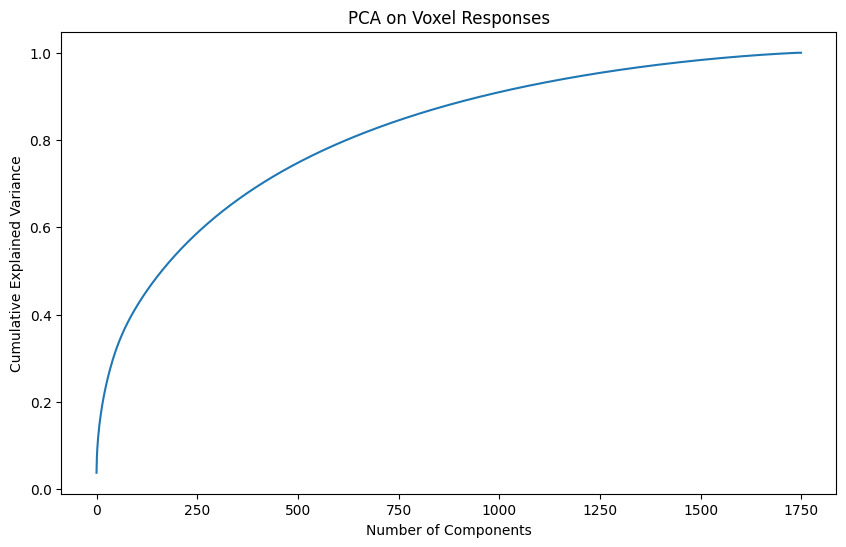

In [ ]:
pca = PCA()
pca_result = pca.fit_transform(y_train.T)
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA on Voxel Responses')
plt.show()

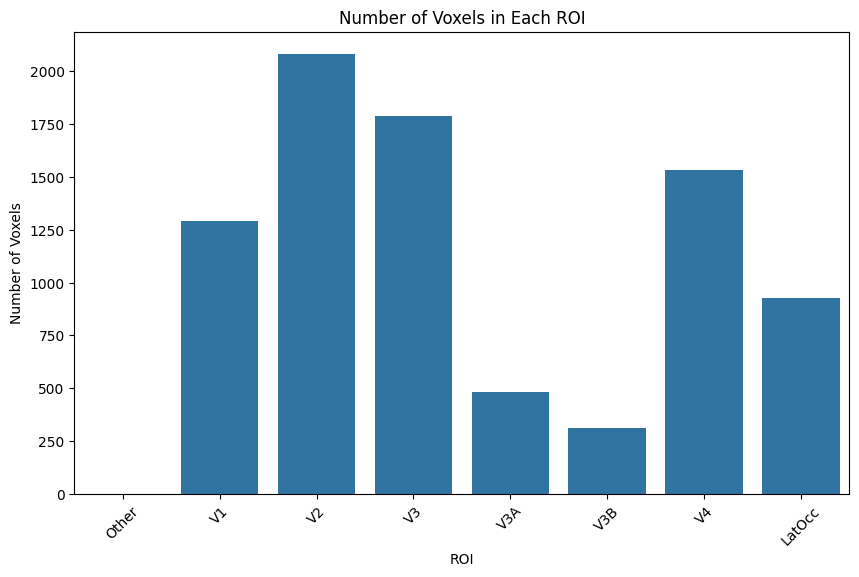

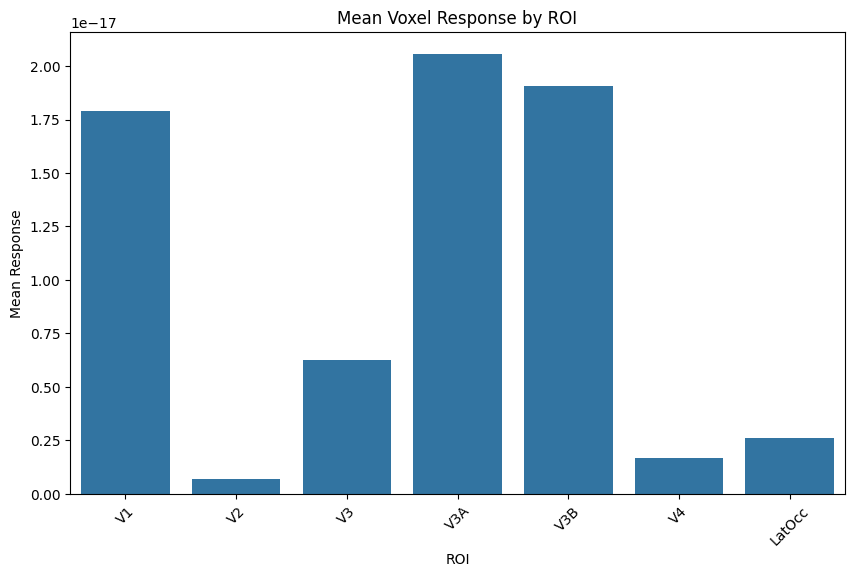

In [ ]:


roi_counts = dict(zip(dat["roi_names"], np.bincount(dat["roi"])))
plt.figure(figsize=(10, 6))
sns.barplot(x=list(roi_counts.keys()), y=list(roi_counts.values()))
plt.title("Number of Voxels in Each ROI")
plt.xlabel("ROI")
plt.ylabel("Number of Voxels")
plt.xticks(rotation=45)
plt.show()

def get_roi_indices(roi_name):
    return np.where(dat["roi_names"][dat["roi"]] == roi_name)[0]

roi_mean_responses = {roi: y_train[:, get_roi_indices(roi)].mean() for roi in roi_counts.keys() if roi != 'Other'}

plt.figure(figsize=(10, 6))
sns.barplot(x=list(roi_mean_responses.keys()), y=list(roi_mean_responses.values()))
plt.title("Mean Voxel Response by ROI")
plt.xlabel("ROI")
plt.ylabel("Mean Response")
plt.xticks(rotation=45)
plt.show()

In [ ]:

def get_activations(model, stimuluslist, layers_of_interest):
    model.eval()

    def reshape_to_2d(x):
        if x.ndim == 1:
            side = int(np.sqrt(x.shape[0]))
            return x.reshape(side, side)
        return x

    def grayscale_to_rgb(x):
        return x.repeat(3, 1, 1)

    resize_normalize = transforms.Compose([
        transforms.Lambda(reshape_to_2d),
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Lambda(grayscale_to_rgb),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    activations_dict = {layer: [] for layer in layers_of_interest}

    hooks = []
    def get_activation(name):
        def hook(model, input, output):
            activations_dict[name].append(output.detach().cpu().numpy().reshape(1, -1))
        return hook

    for layer_name, layer in layers_of_interest.items():
        hooks.append(layer.register_forward_hook(get_activation(layer_name)))

    for image_idx, image in enumerate(tqdm(stimuluslist)):
        if not isinstance(image, np.ndarray):
            image = np.array(image)
        input_img = resize_normalize(image).unsqueeze(0)

        if torch.cuda.is_available():
            input_img = input_img.cuda()
            model = model.cuda()

        with torch.no_grad():
            model(input_img)

    for hook in hooks:
        hook.remove()

    for layer in layers_of_interest:
        activations_dict[layer] = np.vstack(activations_dict[layer]) if activations_dict[layer] else None

    return activations_dict

def fit_pca_on_activations(activations, n_components=120):
    pca_models = {}
    transformed_activations = {}
    for layer, act in activations.items():
        if act is not None:
            scaler = StandardScaler()
            act = scaler.fit_transform(act)
            pca = PCA(n_components=n_components)
            transformed_activations[layer] = pca.fit_transform(act)
            pca_models[layer] = (scaler, pca)
            print(f"Layer {layer}: Number of components after PCA: {pca.n_components_}")
            print(f"Layer {layer}: Explained variance ratio: {sum(pca.explained_variance_ratio_):.2f}")
        else:
            print(f"No activations found for layer: {layer}")
            pca_models[layer] = (None, None)
    return pca_models, transformed_activations

def apply_pca_on_test_activations(activations, pca_models):
    transformed_activations = {}
    for layer, act in activations.items():
        if act is not None:
            scaler, pca = pca_models[layer]
            act = scaler.transform(act)
            transformed_activations[layer] = pca.transform(act)
            print(f"Layer {layer}: Number of components after PCA: {pca.n_components_}")
            print(f"Layer {layer}: Explained variance ratio: {sum(pca.explained_variance_ratio_):.2f}")
        else:
            print(f"No activations found for layer: {layer}")
            transformed_activations[layer] = None
    return transformed_activations

alexnet = models.alexnet(weights='AlexNet_Weights.DEFAULT')

layers_of_interest = {
    'conv1': alexnet.features[0],
    'conv2': alexnet.features[3],
    'conv3': alexnet.features[6],
    'conv4': alexnet.features[8],
    'conv5': alexnet.features[10],
    'fc6': alexnet.classifier[0],
    'fc7': alexnet.classifier[3],
    'fc8': alexnet.classifier[6]
}


train_activations = get_activations(alexnet, X_train, layers_of_interest)
test_activations = get_activations(alexnet, X_test, layers_of_interest)

pca_models, train_activations_pca = fit_pca_on_activations(train_activations)
test_activations_pca = apply_pca_on_test_activations(test_activations, pca_models)



100%|██████████| 120/120 [00:00<00:00, 197.00it/s]


Layer conv1: Number of components after PCA: 300
Layer conv1: Explained variance ratio: 0.45
Layer conv2: Number of components after PCA: 300
Layer conv2: Explained variance ratio: 0.75
Layer conv3: Number of components after PCA: 300
Layer conv3: Explained variance ratio: 0.77
Layer conv4: Number of components after PCA: 300
Layer conv4: Explained variance ratio: 0.72
Layer conv5: Number of components after PCA: 300
Layer conv5: Explained variance ratio: 0.77
Layer fc6: Number of components after PCA: 300
Layer fc6: Explained variance ratio: 0.59
Layer fc7: Number of components after PCA: 300
Layer fc7: Explained variance ratio: 0.77
Layer fc8: Number of components after PCA: 300
Layer fc8: Explained variance ratio: 0.99
Layer conv1: Number of components after PCA: 300
Layer conv1: Explained variance ratio: 0.45
Layer conv2: Number of components after PCA: 300
Layer conv2: Explained variance ratio: 0.75
Layer conv3: Number of components after PCA: 300
Layer conv3: Explained variance r

In [ ]:
roi_responses_scaled = {}
roi_responses_test_scaled = {}
roi_responses.pop('Other', None)
roi_responses_test.pop('Other', None)
for roi in roi_responses:
    scaler_fmri = StandardScaler()
    roi_responses_scaled[roi] = scaler_fmri.fit_transform(roi_responses[roi])
    roi_responses_test_scaled[roi] = scaler_fmri.transform(roi_responses_test[roi])

In [ ]:
class RidgeRegressionPyTorch(object):
    def __init__(self, alpha=1.0, use_gpu=False):
        self.alpha = alpha
        self.coefficients = []
        self.use_gpu = use_gpu

    def fit(self, X, y):
        if len(X.shape) == 1:
            X = self._reshape_x(X)
        if len(y.shape) == 1:
            y = self._reshape_x(y)

        X = self._concatenate_ones(X)

        X = torch.from_numpy(X).float()
        y = torch.from_numpy(y).float()
        if self.use_gpu:
            X = X.cuda()
            y = y.cuda()

        XtX = torch.matmul(X.t(), X)
        Xty = torch.matmul(X.t(), y.unsqueeze(2))

        ridge_term = self.alpha * torch.eye(XtX.shape[1])
        if self.use_gpu:
            ridge_term = ridge_term.cuda()

        XtX += ridge_term

        XtX = XtX.unsqueeze(0)
        XtX = torch.repeat_interleave(XtX, y.shape[0], dim=0)

        betas_cholesky = torch.linalg.solve(XtX, Xty)

        self.coefficients = betas_cholesky

    def predict(self, entry):
        if len(entry.shape) == 1:
            entry = self._reshape_x(entry)
        entry = self._concatenate_ones(entry)
        entry = torch.from_numpy(entry).float()
        if self.use_gpu:
            entry = entry.cuda()
        prediction = torch.matmul(entry, self.coefficients)
        prediction = prediction.cpu().numpy()
        prediction = np.squeeze(prediction).T
        return prediction

    def _reshape_x(self, X):
        return X.reshape(-1, 1)

    def _concatenate_ones(self, X):
        ones = np.ones(shape=X.shape[0]).reshape(-1, 1)
        return np.concatenate((ones, X), 1)

In [ ]:
def predict_fmri_fast(train_activations, test_activations, train_fmri,use_gpu=False):
    """This function fits a linear regressor using train_activations and train_fmri,
    then returns the predicted fmri_pred_test using the fitted weights and
    test_activations.

    Parameters
    ----------
    train_activations : np.array
        matrix of dimensions #train_vids x #pca_components
        containing activations of train videos.
    test_activations : np.array
        matrix of dimensions #test_vids x #pca_components
        containing activations of test videos
    train_fmri : np.array
        matrix of dimensions #train_vids x  #voxels
        containing fMRI responses to train videos
    use_gpu : bool
        Description of parameter `use_gpu`.

    Returns
    -------
    fmri_pred_test: np.array
        matrix of dimensions #test_vids x  #voxels
        containing predicted fMRI responses to test videos .

    """

    reg = RidgeRegressionPyTorch(alpha=1, use_gpu=use_gpu)
    reg.fit(train_activations,train_fmri.T)
    fmri_pred_test = reg.predict(test_activations)
    return fmri_pred_test

In [ ]:

def reshape_if_needed(array):
    if len(array.shape) == 1:
        array = array.reshape(1, -1)
    return array

train_activations_pca_reshaped = {layer: reshape_if_needed(act) for layer, act in train_activations_pca.items()}
test_activations_pca_reshaped = {layer: reshape_if_needed(act) for layer, act in test_activations_pca.items()}
roi_responses_reshaped = {roi: reshape_if_needed(res) for roi, res in roi_responses_scaled.items()}

predicted_responses = predict_fmri_fast(
    train_activations_pca_reshaped['conv1'],
    test_activations_pca_reshaped['conv1'],
    roi_responses_reshaped['V1']
)

In [ ]:
print("Shape of predicted_responses:", predicted_responses.shape)
print("Shape of roi_responses_test['V1']:", roi_responses_test['V1'].shape)

Shape of predicted_responses: (120, 1294)
Shape of roi_responses_test['V1']: (120, 1294)


Mean Pearson correlation across voxels: 0.012


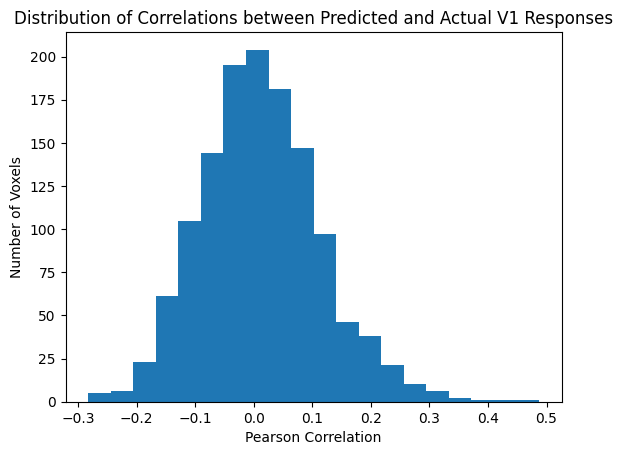

In [ ]:

from scipy.stats import pearsonr


correlations = []
for i in range(predicted_responses.shape[1]):
    r, _ = pearsonr(predicted_responses[:, i], roi_responses_test['V1'][:, i])
    correlations.append(r)

correlations = np.array(correlations)
mean_correlation = np.mean(correlations)

print(f"Mean Pearson correlation across voxels: {mean_correlation:.3f}")
import matplotlib.pyplot as plt
plt.hist(correlations, bins=20)
plt.xlabel("Pearson Correlation")
plt.ylabel("Number of Voxels")
plt.title("Distribution of Correlations between Predicted and Actual V1 Responses")
plt.show()


ROI: V1, Layer: conv1, Mean Pearson correlation: 0.012
ROI: V1, Layer: conv2, Mean Pearson correlation: 0.137
ROI: V1, Layer: conv3, Mean Pearson correlation: 0.139
ROI: V1, Layer: conv4, Mean Pearson correlation: 0.151
ROI: V1, Layer: conv5, Mean Pearson correlation: 0.137
ROI: V1, Layer: fc6, Mean Pearson correlation: 0.118
ROI: V1, Layer: fc7, Mean Pearson correlation: 0.085
ROI: V1, Layer: fc8, Mean Pearson correlation: 0.097
ROI: V2, Layer: conv1, Mean Pearson correlation: 0.018
ROI: V2, Layer: conv2, Mean Pearson correlation: 0.103
ROI: V2, Layer: conv3, Mean Pearson correlation: 0.108
ROI: V2, Layer: conv4, Mean Pearson correlation: 0.121
ROI: V2, Layer: conv5, Mean Pearson correlation: 0.105
ROI: V2, Layer: fc6, Mean Pearson correlation: 0.094
ROI: V2, Layer: fc7, Mean Pearson correlation: 0.059
ROI: V2, Layer: fc8, Mean Pearson correlation: 0.069
ROI: V3, Layer: conv1, Mean Pearson correlation: 0.011
ROI: V3, Layer: conv2, Mean Pearson correlation: 0.056
ROI: V3, Layer: conv3,

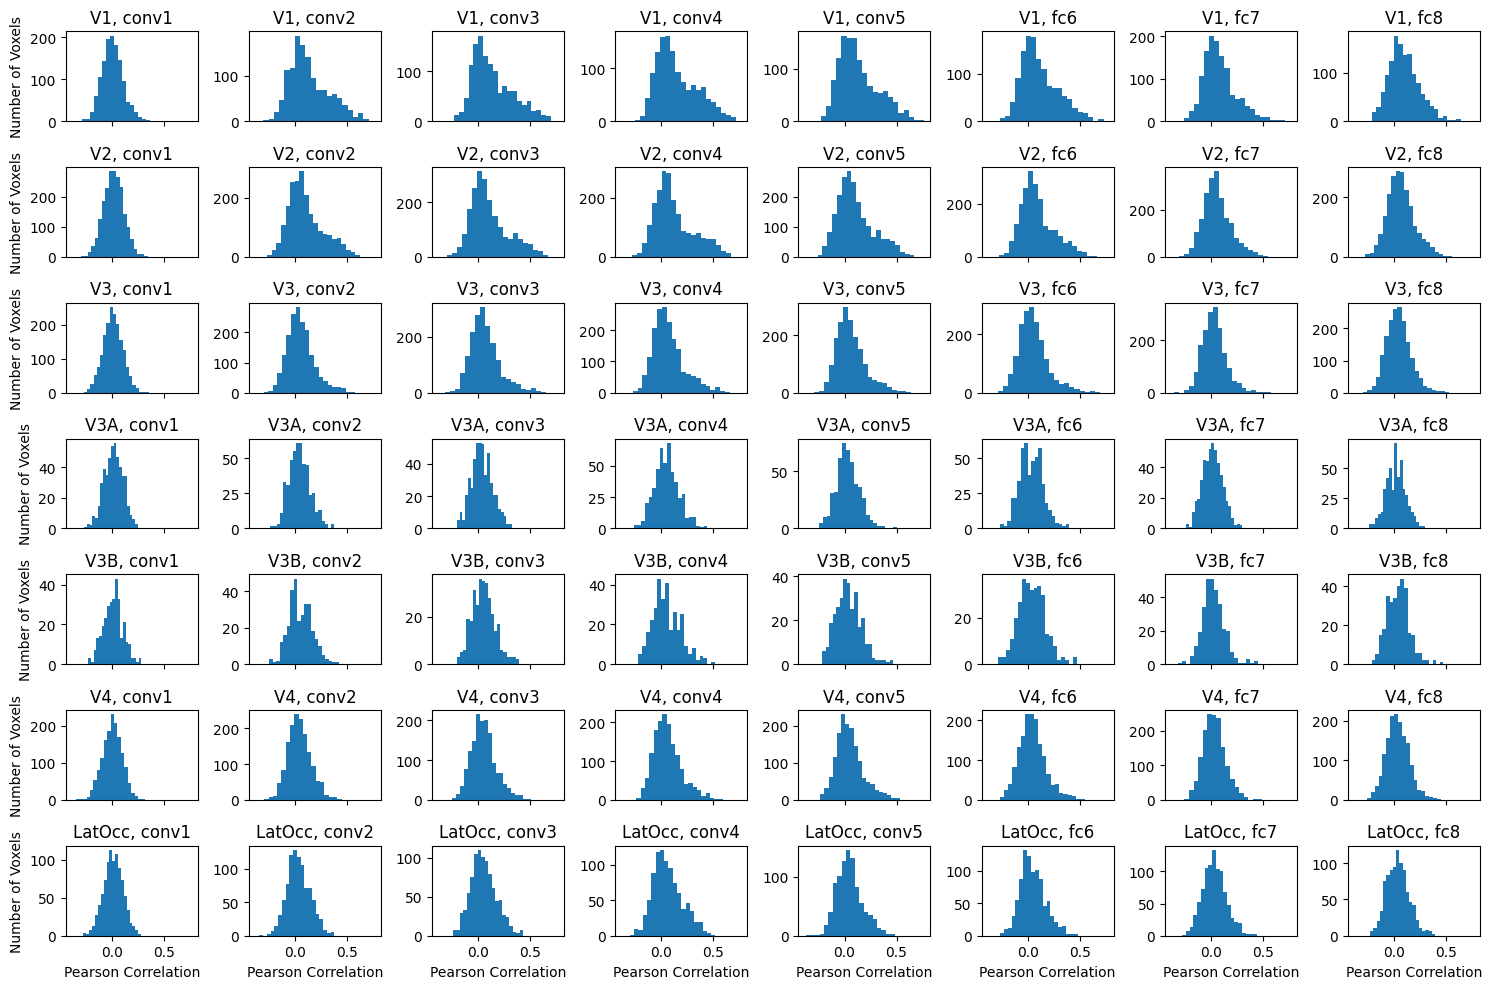

In [ ]:


def calculate_and_plot_correlations(predictions, actual_responses, roi_name, layer_name):
    """Calculates and plots Pearson correlations (voxel-wise)."""

    correlations = []
    for i in range(predictions.shape[1]):
        r, _ = pearsonr(predictions[:, i], actual_responses[:, i])
        correlations.append(r)

    mean_correlation = np.mean(correlations)
    print(f"ROI: {roi_name}, Layer: {layer_name}, Mean Pearson correlation: {mean_correlation:.3f}")

    plt.figure()
    plt.hist(correlations, bins=20)
    plt.xlabel("Pearson Correlation")
    plt.ylabel("Number of Voxels")
    plt.title(f"Correlations: {roi_name}, {layer_name}")
    plt.show()

fig, axes = plt.subplots(len(roi_responses_reshaped), len(layers_of_interest),
                         figsize=(15, 10), sharex=True)  # Adjust figsize as needed

for roi_idx, roi_name in enumerate(roi_responses_reshaped):
    for layer_idx, layer_name in enumerate(layers_of_interest):

        predicted_responses = predict_fmri_fast(
            train_activations_pca_reshaped[layer_name],
            test_activations_pca_reshaped[layer_name],
            roi_responses_reshaped[roi_name]
        )

        correlations = []
        for i in range(predicted_responses.shape[1]):
            r, _ = pearsonr(predicted_responses[:, i], roi_responses_test[roi_name][:, i])
            correlations.append(r)

        mean_correlation = np.mean(correlations)
        print(f"ROI: {roi_name}, Layer: {layer_name}, Mean Pearson correlation: {mean_correlation:.3f}")

        axes[roi_idx, layer_idx].hist(correlations, bins=20)
        axes[roi_idx, layer_idx].set_title(f"{roi_name}, {layer_name}")
        axes[roi_idx, layer_idx].set_xlabel("Pearson Correlation" if roi_idx == len(roi_responses_reshaped) - 1 else "")
        axes[roi_idx, layer_idx].set_ylabel("Number of Voxels" if layer_idx == 0 else "")

plt.tight_layout()
plt.show()

In [ ]:
import plotly.graph_objects as go
mean_correlations = np.zeros((len(roi_responses_reshaped), len(layers_of_interest)))
for roi_idx, roi_name in enumerate(roi_responses_reshaped):
    for layer_idx, layer_name in enumerate(layers_of_interest):
        predicted_responses = predict_fmri_fast(
            train_activations_pca_reshaped[layer_name],
            test_activations_pca_reshaped[layer_name],
            roi_responses_reshaped[roi_name]
        )

        correlations = []
        for i in range(predicted_responses.shape[1]):
            r, _ = pearsonr(predicted_responses[:, i], roi_responses_test[roi_name][:, i])
            correlations.append(r)

        mean_correlations[roi_idx, layer_idx] = np.mean(correlations)

fig = go.Figure()

for roi_idx, roi_name in enumerate(roi_responses_reshaped):
    fig.add_trace(go.Bar(
        x=list(layers_of_interest),
        y=mean_correlations[roi_idx],
        name=roi_name,
    ))

fig.update_layout(
    barmode='group',
    xaxis_title="AlexNet Layer",
    yaxis_title="Mean Pearson Correlation",
    title="Mean Correlations between Predicted and Actual fMRI Responses"
)

fig.show()